# Testing Algorithm Performance in Off-Policy Setting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import algos
import features
import parametric
import policy
import chicken
from agents import OffPolicyAgent, OnPolicyAgent
from rlbench import *

# Assessing Learning Algorithms

In theory, it is possible to solve for the value function sought by the learning algorithms directly, but in practice approximation will suffice.

In [4]:
# define the experiment
num_states = 8
num_features = 8

# set up environment
env = chicken.Chicken(num_states)

# set up policy
pol_pi = policy.FixedPolicy({s: {0: 1} for s in env.states})

# set feature mapping
# phi = features.RandomBinary(num_features, num_features // 2, random_seed=101011)
phi = features.Int2Unary(num_states)

# run the algorithms for enough time to get reliable convergence
num_steps = 100000

# the TD(1) solution should minimize the mean-squared error
update_params = {
    'gm': 0.9,
    'gm_p': 0.9,
    'lm': 0.0,
}
lstd_1 = OnPolicyAgent(algos.LSTD(phi.length), pol_pi, phi, update_params)
run_episode(lstd_1, env, num_steps)
mse_values = lstd_1.get_values(env.states)

# the TD(0) solution should minimize the MSPBE
update_params = {
    'gm': 0.9,
    'gm_p': 0.9,
    'lm': 0.0,
}
lstd_0 = OnPolicyAgent(algos.LSTD(phi.length), pol_pi, phi, update_params)
run_episode(lstd_0, env, num_steps)
mspbe_values = lstd_0.get_values(env.states)

## What do the target values look like?

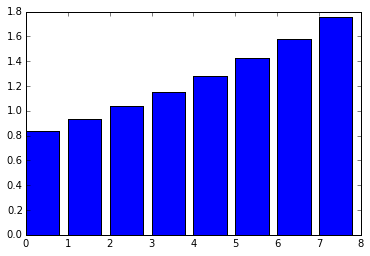

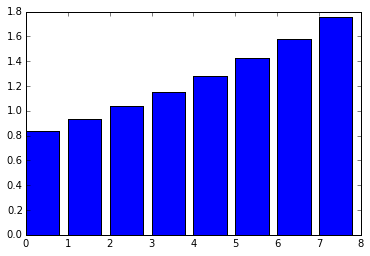

In [5]:
# Plot the states against their target values
xvals = list(sorted(env.states))
y_mse = [mse_values[s] for s in xvals]
y_mspbe = [mspbe_values[s] for s in xvals]

# Mean-square error optimal values
plt.bar(xvals, y_mse)
plt.show()

# MSPBE optimal values
plt.bar(xvals, y_mspbe)
plt.show()

# Actual Testing

We have a number of algorithms that we can try

In [6]:
algos.algo_registry

{'ETD': algos.ETD,
 'GTD': algos.GTD,
 'GTD2': algos.GTD2,
 'LSTD': algos.LSTD,
 'TD': algos.TD,
 'TDC': algos.TDC}

These algorithms are given to `OffPolicyAgent`, which also takes care of the function approximation and manages the parameters given to the learning algorithm.

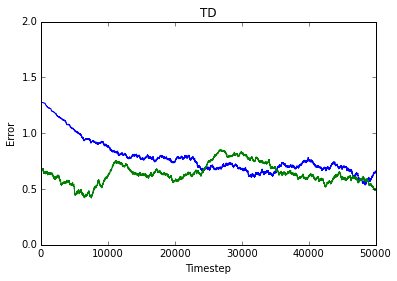

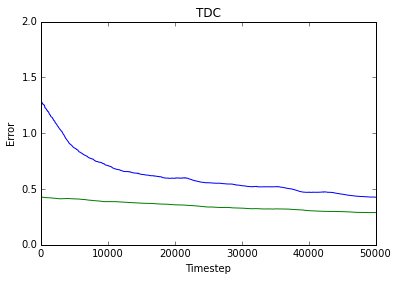

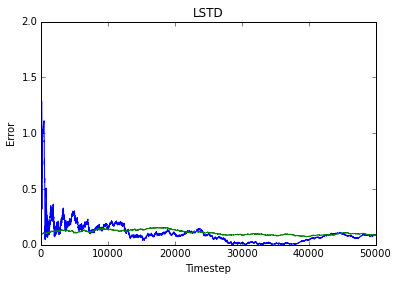

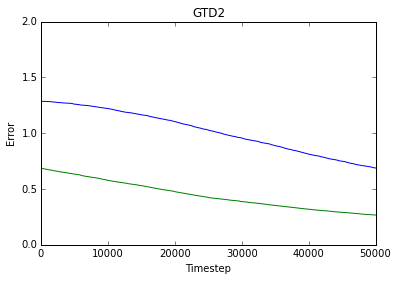

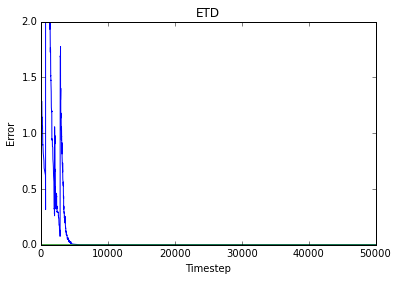

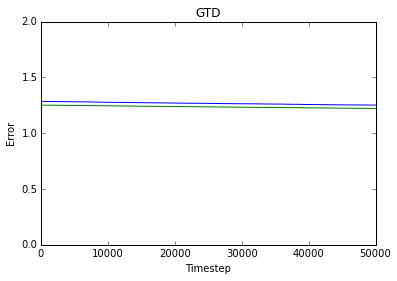

In [7]:
# set up algorithm parameters
update_params = {
    'alpha': 0.02,
    'beta': 0.002,
    'gm': 0.9,
    'gm_p': 0.9,
    'lm': 0.0,
    'lm_p': 0.0,
    'interest': 1.0,
}

# Define the target policy
pol_pi = policy.FixedPolicy({s: {0: 1} for s in env.states})
# Define the behavior policy
pol_mu = policy.FixedPolicy({s: {0: 1} if s < 4 else {0: 0.5, 1: 0.5} for s in env.states})


# Run all available algorithms 
max_steps = 50000
for name, alg in algos.algo_registry.items():    
    # Set up the agent, run the experiment, get state-values
    agent = OffPolicyAgent(alg(phi.length), pol_pi, pol_mu, phi, update_params)
    mse_lst = run_errors(agent, env, max_steps, mse_values)
    mspbe_lst = run_errors(agent, env, max_steps, mspbe_values)

    # Plot the errors
    xdata = np.arange(max_steps)
    plt.plot(xdata, mse_lst)
    plt.plot(xdata, mspbe_lst)
#     plt.plot(xdata, np.log(mse_lst))
#     plt.plot(xdata, np.log(mspbe_lst))
    
    # Format and label the graph
    plt.ylim(0, 2)
    plt.title(name)
    plt.xlabel('Timestep')
    plt.ylabel('Error')
    plt.show()